# 02b - Protocol Usage
Understand flash loan usage across different protocols.

In [188]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn.objects as so

## Ethereum Category Distribution

In [6]:
df = pd.read_parquet("../data/flash_loans/ethereum_flash_loans.parquet")

In [210]:
(
    df.
    groupby('protocol')
    .amount_usd
    .count()
    .sort_values(ascending=False)
)

protocol
Uniswap V2           160026
Balancer V2          137624
SushiSwap             59007
dYdX V1               56040
Aave V2               45253
Aave V1               24050
Maker V1              22973
Aave V3               16543
DODO V2                6471
Euler Finance V1       4848
Uniswap V3             3928
Spark Protocol V1      2791
Morpho Blue V1         2604
Equalizer V1            193
Aave V2 (AMM)           157
ZeroLend V1              15
Synapse V1                1
Fiat DAO V1               0
Name: amount_usd, dtype: int64

In [52]:
protocol_dict = {
    'Uniswap V2': 'Flash Swap',
    'Balancer V2': 'Flash Loan',
    'SushiSwap': 'Flash Swap',
    'dYdX V1': 'Flash Loan',
    'Aave V1': 'Flash Loan',
    'Aave V2': 'Flash Loan',
    'Aave V3': 'Flash Loan',
    'DODO V2': 'Flash Swap',
    'Euler Finance V1': 'Flash Loan',
    'Uniswap V3': 'Flash Swap',
    'Maker V1': 'Flash Mint',
    'Spark Protocol V1': 'Flash Loan',
    'Morpho Blue V1': 'Flash Loan'
}

In [233]:
df.symbol.value_counts()[0:10]

symbol
WETH      190594
USDC       73938
DAI        69058
TENSHI     61010
USDT       33112
WBTC       14274
ETH        10240
UNI-V2      7375
LINK        5324
CRV         4850
Name: count, dtype: int64

In [276]:
df.groupby('protocol')['amount_usd'].sum().sort_values(ascending=False)[0:10]

protocol
Maker V1             6.665838e+11
Balancer V2          6.454207e+11
dYdX V1              3.219355e+11
Aave V2              1.321201e+10
Spark Protocol V1    1.262978e+10
Morpho Blue V1       1.235483e+10
Aave V3              7.708722e+09
Uniswap V2           4.580481e+09
Aave V1              4.220016e+09
Uniswap V3           2.905032e+09
Name: amount_usd, dtype: float64

In [282]:
df['flash_type'] = df['protocol'].map(protocol_dict)
df['flash_source'] = np.select(
    [df['flash_type'] == 'Flash Loan', df['flash_type'] == 'Flash Swap', df['flash_type'] == 'Flash Mint'],
    ['Vault', 'AMM Pool', 'Mint'],
    ['Vault']
)

df['token_symbol'] = np.select(
    [df['symbol'].isin(['WETH', 'ETH']), df['symbol'].isin(['WBTC', 'DAI', 'USDT', 'USDC'])],
    ['ETH/WETH', df['symbol']],
    'Other'
)

df['protocol_category'] = np.where(
    df['protocol'].isin(['Maker V1', 'Balancer V2','Uniswap V2', 'Aave V2', 'Spark Protocol V1', 'Morpho Blue V1', 'dYdX V1']),
    df['protocol'],
    'Other'
)

## Flash Loans, by Type of Flash Mechanism
* Flash loans created from AMM pools are smaller based on total size, but more numerous, and more variety in tokens.
* Flash loans created from vaults are larger from the distribution due to the depth of liquidity pools
* Flash loans created from minting are distributed to personal preference (100m DAI set by a few bots) or the system parameters (500m DAI is the max)

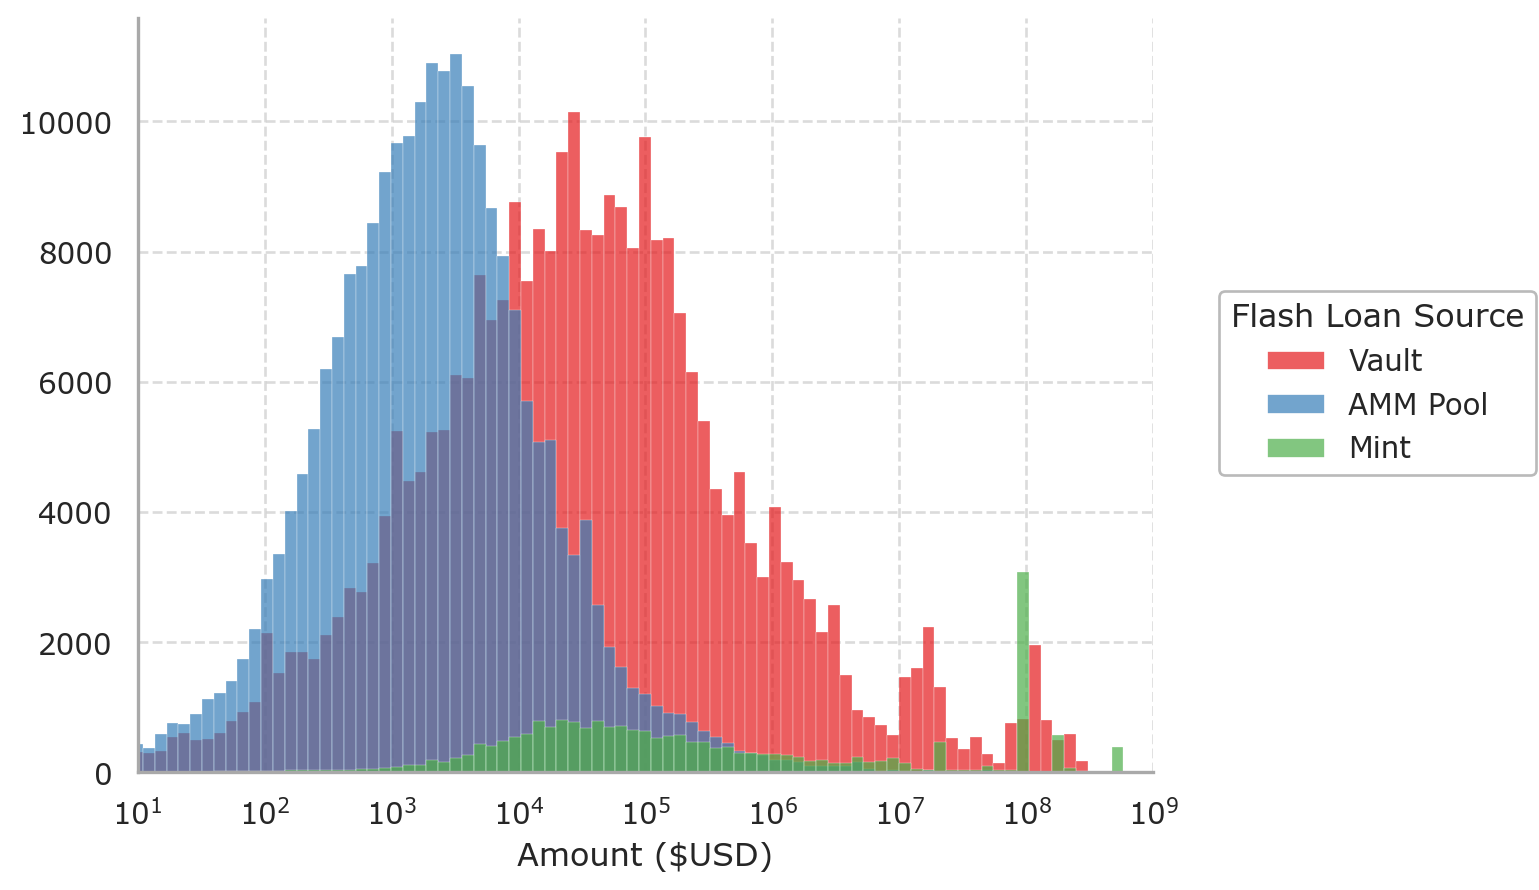

In [223]:
sns.set_palette('Set2')
p = (
    so.Plot(
        df.query("amount_usd > 0"),
        x="amount_usd", 
        color='flash_source',
    )
    .add(so.Bars(alpha=0.7), so.Hist(bins=300))
    .scale(x="log", color='Set1')
    .limit(x=(10, 10**9))
    ).label(
        x='Amount ($USD)', y='', color='Flash Loan Source'
    ).layout(
        size=(6.4,4.8),
        engine='tight'
    )

p = p.theme(
    {"axes.facecolor": "w",
     "axes.edgecolor": "darkgrey",
     "font.family": 'sans-serif', 
     'font.sans-serif':'Verdana',
     'axes.spines.top':False,
     'axes.spines.right':False,
     'axes.grid':True,
     'axes.grid.axis': 'both',
     'axes.axisbelow':True,
     'grid.color':'#D3D3D3',
     'grid.linestyle':'--',
     'grid.alpha':0.8,
     'legend.edgecolor':'darkgrey'
     }
    )
p.save("../figures/protocols/hist_ethereum_value.svg", bbox_inches='tight')

In [185]:
df.groupby('flash_type')['symbol'].nunique()

flash_type
Flash Loan     137
Flash Mint       1
Flash Swap    5417
Name: symbol, dtype: int64

In [186]:
df.groupby('protocol')['symbol'].nunique()

protocol
Aave V1                20
Aave V2                36
Aave V2 (AMM)           4
Aave V3                29
Balancer V2           122
DODO V2                28
Equalizer V1            6
Euler Finance V1       18
Fiat DAO V1             1
Maker V1                1
Morpho Blue V1         15
Spark Protocol V1       8
SushiSwap             674
Synapse V1              1
Uniswap V2           5182
Uniswap V3            174
ZeroLend V1             4
dYdX V1                 3
Name: symbol, dtype: int64

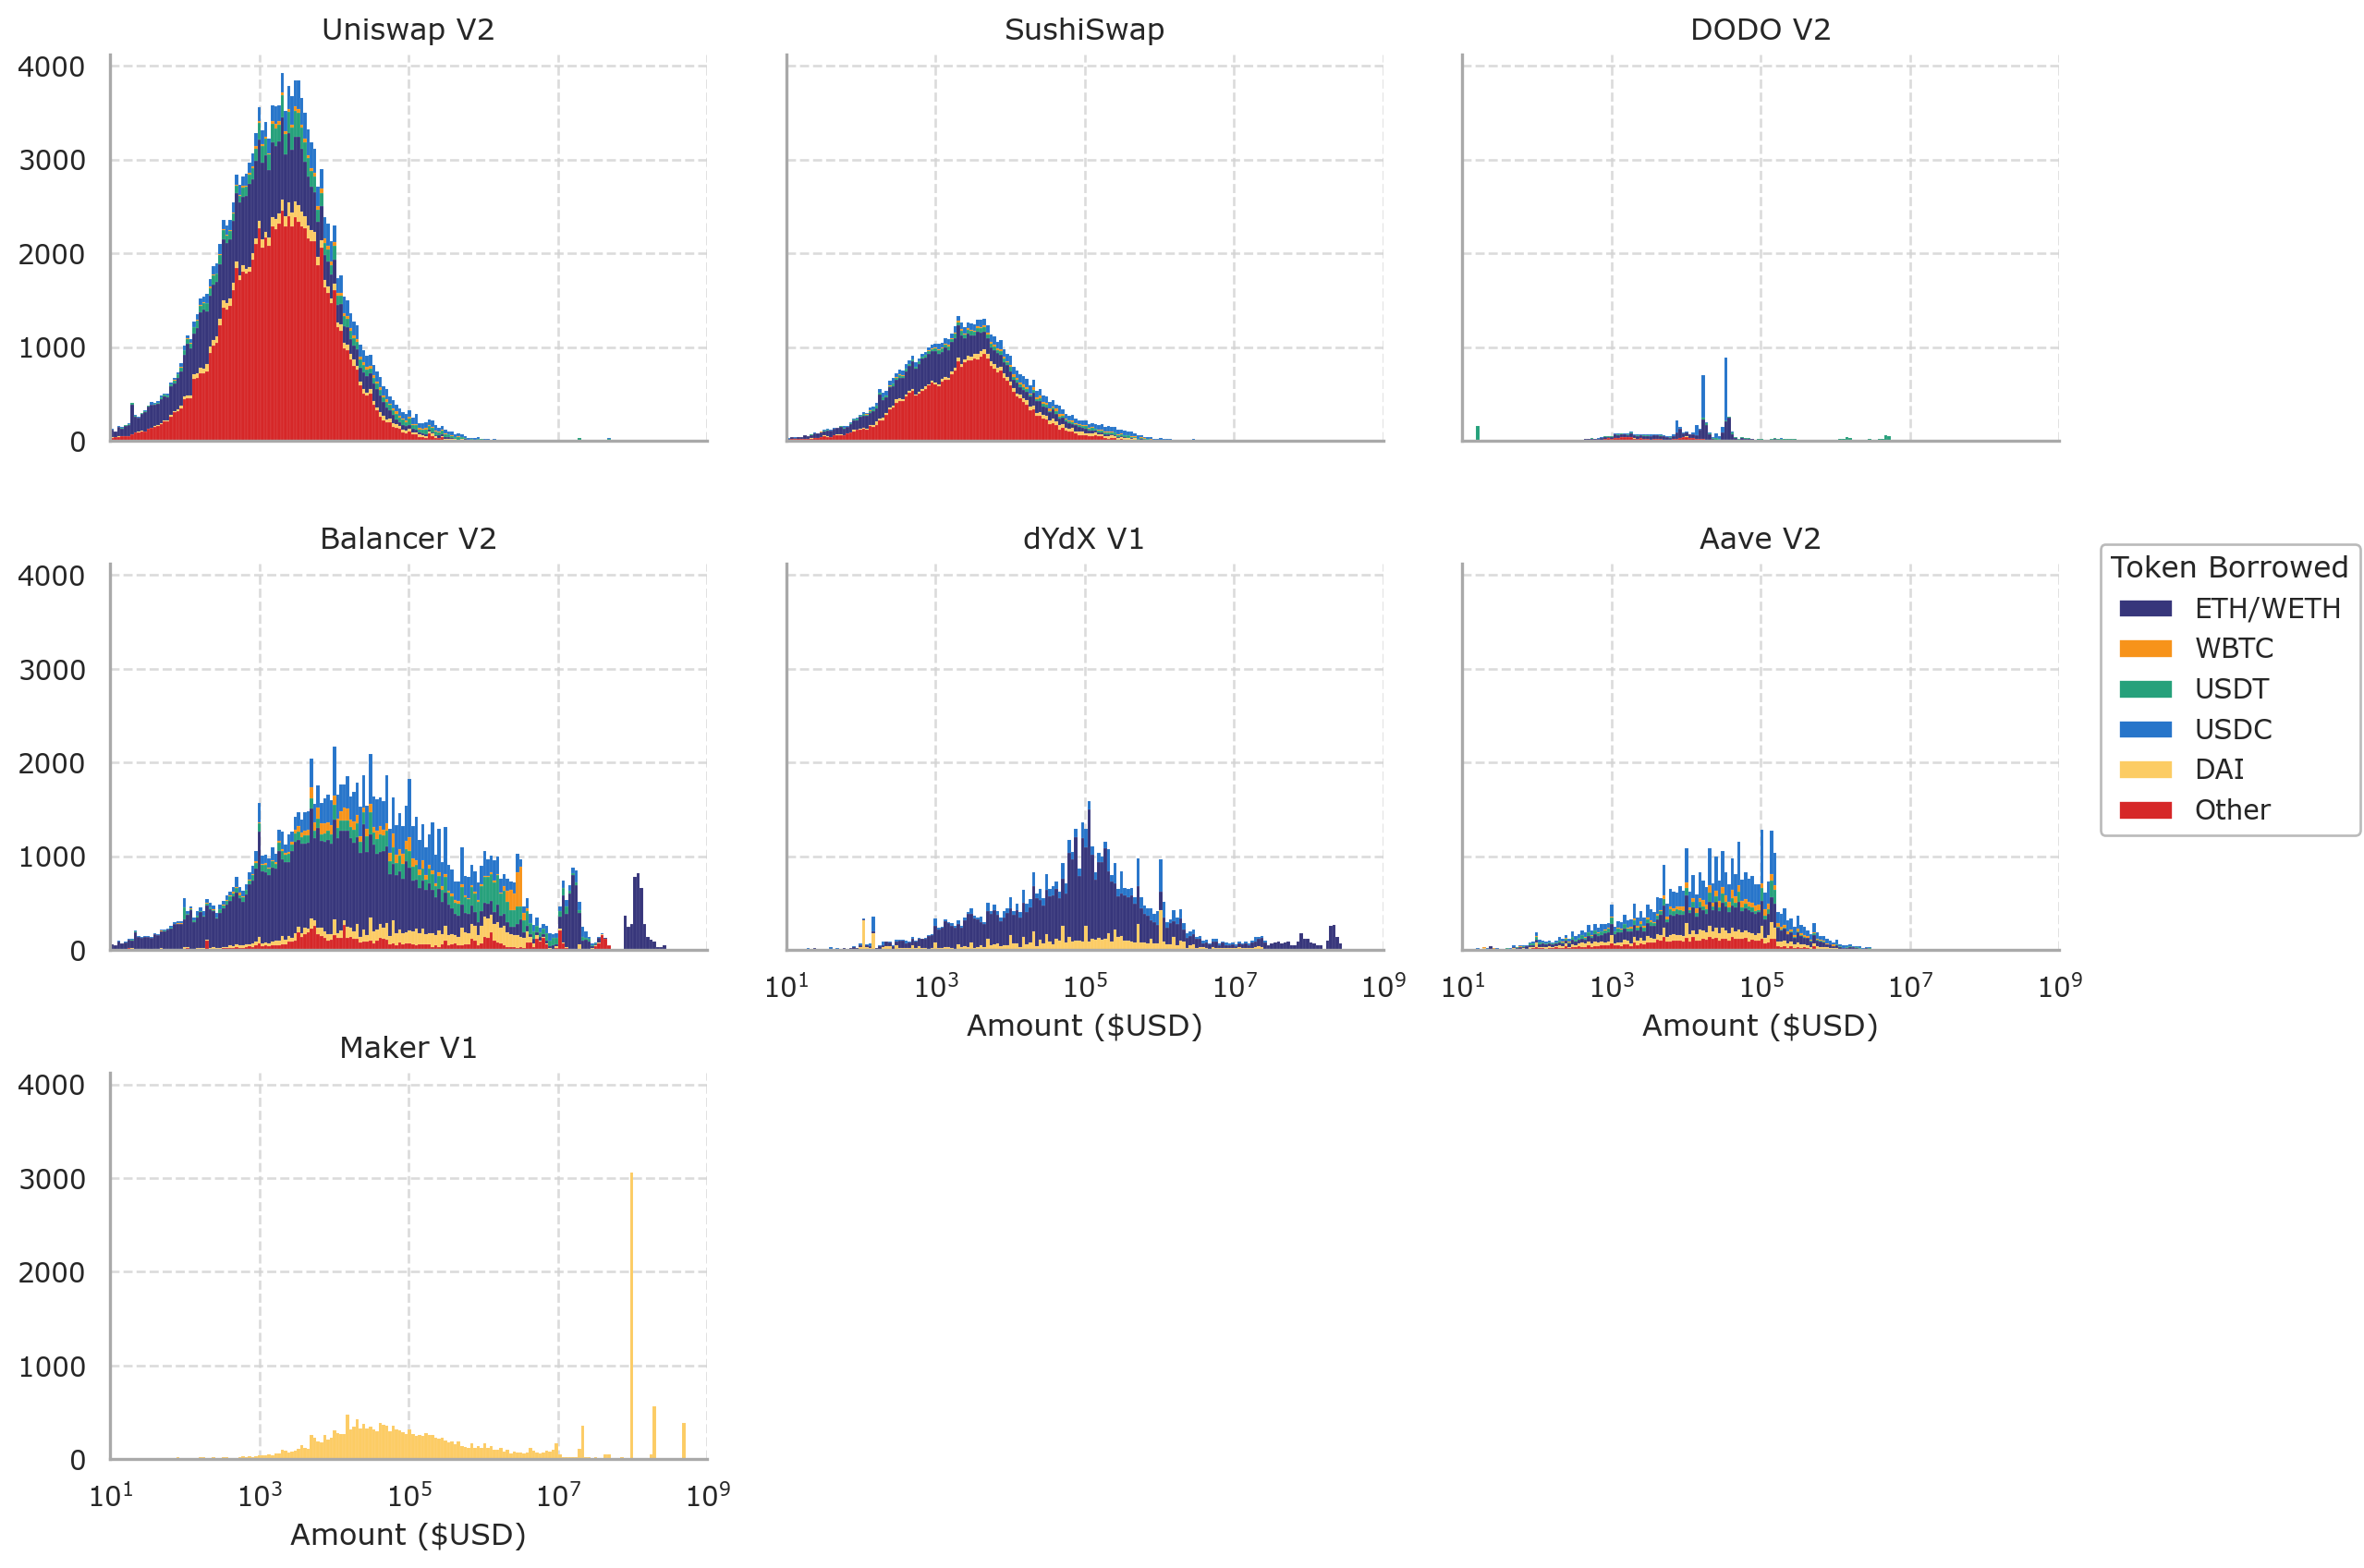

In [236]:
p = (
    so.Plot(
        df.query("amount_usd > 0 and protocol in ['Uniswap V2', 'SushiSwap', 'DODO V2', 'Balancer V2', 'dYdX V1','Aave V2', 'Maker V1']"),
        x="amount_usd",
        color='token_symbol',
    )
    .add(so.Bars(alpha=1), so.Hist(), so.Stack())
    .facet("protocol", wrap=3, order=['Uniswap V2', 'SushiSwap', 'DODO V2', 'Balancer V2', 'dYdX V1','Aave V2', 'Maker V1'])
    .scale(
        x="log",
        color=so.Nominal(['#37367b', '#f7931a', '#26A17B', '#2775ca', '#fccc64', 'tab:red'], order=['ETH/WETH', 'WBTC', 'USDT', 'USDC', 'DAI', 'Other']),
    ).limit(x=(10, 10**9))
    #.share(x=False)
    ).label(
        x='Amount ($USD)', y='', color='Token Borrowed'
    ).layout(
        size=(12,9),
        engine='tight'
    )

p = p.theme(
    {"axes.facecolor": "w",
     "axes.edgecolor": "darkgrey",
     "font.family": 'sans-serif', 
     'font.sans-serif':'Verdana',
     'axes.spines.top':False,
     'axes.spines.right':False,
     'axes.grid':True,
     'axes.grid.axis': 'both',
     'axes.axisbelow':True,
     'grid.color':'#D3D3D3',
     'grid.linestyle':'--',
     'grid.alpha':0.8,
     'legend.edgecolor':'darkgrey'
     }
    )

p.save("../figures/protocols/hist_facet_ethereum_protocol_value.svg", bbox_inches='tight')

In [284]:
dft = (
    df
    .assign(
        date = lambda x: pd.to_datetime(x.evt_block_time),
    )
    .groupby([pd.Grouper(key='date', freq='W'), 'protocol_category', 'token_symbol'])
    .agg({'amount_usd':['sum', 'count']})
    .reset_index()
    .set_axis(['date', 'protocol_category', 'token_symbol', 'value', 'num'], axis=1)
    .assign(
        value = lambda x: x.value/1e+9
    )
    .copy()
)
dft.head()

,date,protocol_category,token_symbol,value,num
0,2020-01-19 00:00:00+00:00,Other,DAI,9.296203e-06,5
1,2020-01-26 00:00:00+00:00,Other,DAI,1.634571e-07,1
2,2020-02-09 00:00:00+00:00,Other,DAI,2.519531e-07,7
3,2020-02-16 00:00:00+00:00,Other,DAI,1.973412e-06,28
4,2020-02-16 00:00:00+00:00,dYdX V1,ETH/WETH,2.758633e-03,1


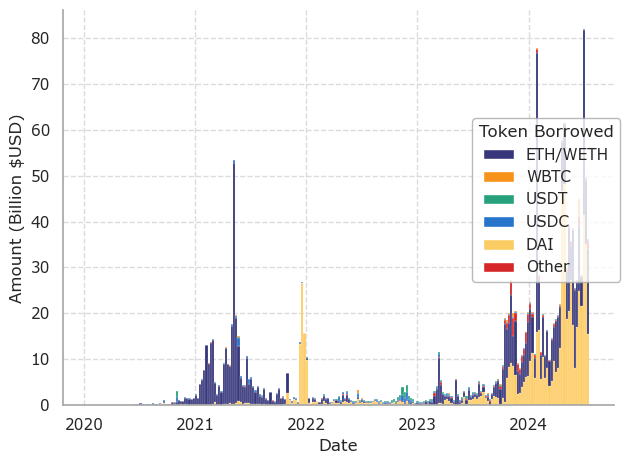

In [272]:
p = so.Plot(
    dft.groupby(['date', 'token_symbol'],as_index=False)['value'].sum(),
    x='date',
    y='value',
    color='token_symbol'
).add(
    so.Bars(alpha=1),
    so.Stack()
).scale(
        color=so.Nominal(['#37367b', '#f7931a', '#26A17B', '#2775ca', '#fccc64', 'tab:red'], order=['ETH/WETH', 'WBTC', 'USDT', 'USDC', 'DAI', 'Other'])
    ).label(
        x='Date', y='Amount (Billion $USD)', color='Token Borrowed'
    ).layout(
        size=(6.4,4.8),
        engine='tight'
    )
    

p = p.theme(
    {"axes.facecolor": "w",
     "axes.edgecolor": "darkgrey",
     "font.family": 'sans-serif', 
     'font.sans-serif':'Verdana',
     'axes.spines.top':False,
     'axes.spines.right':False,
     'axes.grid':True,
     'axes.grid.axis': 'both',
     'axes.axisbelow':True,
     'grid.color':'#D3D3D3',
     'grid.linestyle':'--',
     'grid.alpha':0.8,
     'legend.edgecolor':'darkgrey'
     }
    )

p.show()

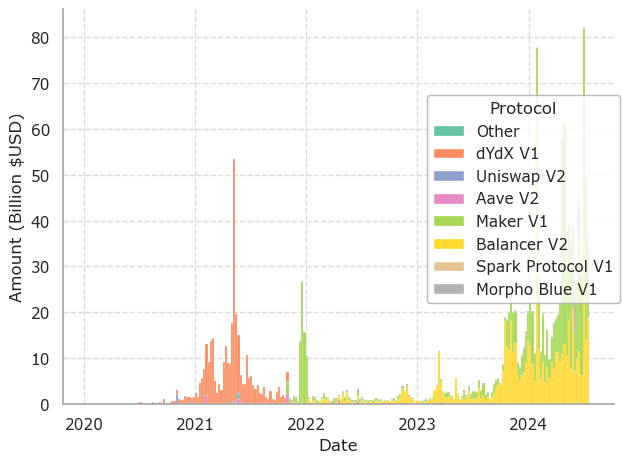

In [285]:
p = so.Plot(
    dft.groupby(['date', 'protocol_category'],as_index=False)['value'].sum(),
    x='date',
    y='value',
    color='protocol_category'
).add(
    so.Bars(alpha=1),
    so.Stack()
).scale(
        color='Set2'
        #color=so.Nominal(['#37367b', '#f7931a', '#26A17B', '#2775ca', '#fccc64', 'tab:red'], order=['ETH/WETH', 'WBTC', 'USDT', 'USDC', 'DAI', 'Other'])
    ).label(
        x='Date', y='Amount (Billion $USD)', color='Protocol'
    ).layout(
        size=(6.4,4.8),
        engine='tight'
    )
    

p = p.theme(
    {"axes.facecolor": "w",
     "axes.edgecolor": "darkgrey",
     "font.family": 'sans-serif', 
     'font.sans-serif':'Verdana',
     'axes.spines.top':False,
     'axes.spines.right':False,
     'axes.grid':True,
     'axes.grid.axis': 'both',
     'axes.axisbelow':True,
     'grid.color':'#D3D3D3',
     'grid.linestyle':'--',
     'grid.alpha':0.8,
     'legend.edgecolor':'darkgrey'
     }
    )

p.show()

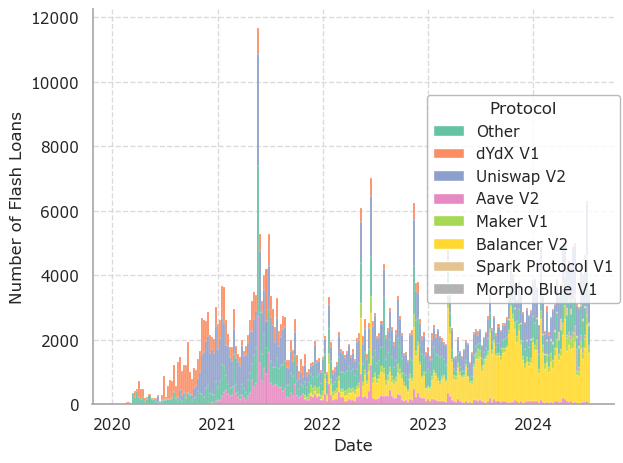

In [287]:
p = so.Plot(
    dft.groupby(['date', 'protocol_category'],as_index=False)['num'].sum(),
    x='date',
    y='num',
    color='protocol_category'
).add(
    so.Bars(alpha=1),
    so.Stack()
).scale(
        color='Set2'
        #color=so.Nominal(['#37367b', '#f7931a', '#26A17B', '#2775ca', '#fccc64', 'tab:red'], order=['ETH/WETH', 'WBTC', 'USDT', 'USDC', 'DAI', 'Other'])
    ).label(
        x='Date', y='Number of Flash Loans', color='Protocol'
    ).layout(
        size=(6.4,4.8),
        engine='tight'
    )
    

p = p.theme(
    {"axes.facecolor": "w",
     "axes.edgecolor": "darkgrey",
     "font.family": 'sans-serif', 
     'font.sans-serif':'Verdana',
     'axes.spines.top':False,
     'axes.spines.right':False,
     'axes.grid':True,
     'axes.grid.axis': 'both',
     'axes.axisbelow':True,
     'grid.color':'#D3D3D3',
     'grid.linestyle':'--',
     'grid.alpha':0.8,
     'legend.edgecolor':'darkgrey'
     }
    )

p.show()

TODO: Check relationship between protocol and token (Sankey chart?)